## Lesson-11 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
![image.png](attachment:image.png)

![image.png](attachment:image.png)

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件

In [4]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2020-07-22 16:22:23--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.84.16.73, 52.84.16.5, 52.84.16.69, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.84.16.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2020-07-22 16:22:23 (26.4 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt

In [37]:
from io import open
import glob
import os
import matplotlib.pyplot as plt


def find_files(path): return glob.glob(path)

print(find_files('data/names/*.txt'))

### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [ ]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [ ]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [ ]:
n_categories

18

In [ ]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))

print(line_to_tensor('Jones').size())

35
torch.Size([5, 1, 57])


In [ ]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

![image.png](attachment:image.png)

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [ ]:
rnn = RNN(n_letters, n_hidden, n_categories)

### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [ ]:
input = letter_to_tensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [ ]:
output

tensor([[-2.9339, -3.0207, -2.8792, -2.8011, -2.9066, -2.9150, -2.8853, -2.8359,
         -3.0154, -2.8345, -2.9008, -2.8958, -2.9266, -2.8768, -2.8879, -2.8857,
         -2.8806, -2.7767]], grad_fn=<LogSoftmaxBackward>)

In [ ]:
next_hidden

tensor([[-4.5417e-02, -9.2074e-02, -9.9323e-02, -8.5756e-02, -3.5325e-02,
         -4.9350e-02,  9.3543e-02, -1.0954e-02,  4.8960e-02,  3.6879e-02,
          1.3318e-03,  2.9163e-02,  1.8872e-02,  7.3214e-02, -4.2261e-02,
          4.9458e-03,  9.5736e-03, -2.3558e-02, -4.5535e-03, -5.4642e-02,
         -1.4570e-02, -9.1193e-02, -5.0531e-04, -4.3820e-02,  8.9702e-03,
          3.3109e-02,  2.4673e-02,  2.5202e-02,  4.0535e-02, -1.5822e-02,
         -5.2994e-02, -8.3962e-02,  7.9832e-02,  3.4034e-02, -4.1505e-02,
         -8.0693e-02,  1.4553e-02, -3.4639e-02, -1.2144e-01, -1.9106e-02,
         -1.8711e-02,  9.9874e-02, -5.2605e-02, -4.4656e-02, -8.4341e-02,
         -7.3961e-02, -6.5679e-02, -3.1707e-02, -1.2021e-02, -9.3402e-02,
         -1.2842e-02,  1.3414e-01, -4.6151e-02, -9.0912e-02, -3.0439e-02,
          5.3734e-02,  3.3195e-02, -5.6682e-02,  5.0456e-02,  7.0209e-02,
         -6.0434e-03, -1.1545e-01, -4.8450e-02,  2.1286e-02, -1.2944e-01,
         -3.3887e-02, -7.6369e-03,  7.

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [ ]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8598, -2.9539, -2.7887, -2.8544, -3.0276, -2.9626, -2.9082, -2.8895,
         -2.8657, -2.9766, -2.8433, -2.9078, -2.9359, -2.8076, -2.8904, -2.7788,
         -2.8957, -2.9172]], grad_fn=<LogSoftmaxBackward>)


这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [ ]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i



对于刚刚产生的output，我们使用这个函数

In [ ]:
print(category_from_output(output))

('English', 15)


### 1.8 随机生成训练数据

In [ ]:
all_categories

['Portuguese',
 'Japanese',
 'Dutch',
 'Polish',
 'Chinese',
 'Arabic',
 'Spanish',
 'Korean',
 'Irish',
 'Czech',
 'French',
 'Greek',
 'German',
 'Russian',
 'Italian',
 'English',
 'Vietnamese',
 'Scottish']

In [ ]:
#category_lines

In [ ]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = Portuguese / line = Pereira
category = Polish / line = Wawrzaszek
category = Portuguese / line = D'cruze
category = Russian / line = Mihailichenko
category = Portuguese / line = Melo
category = Irish / line = Kavanagh
category = Czech / line = Janacek
category = Italian / line = Lamberti
category = Japanese / line = Tsuruga
category = Scottish / line = Hill


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [ ]:
import time
import math

n_iters = 1000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    print(category_tensor.shape)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

### 1.9 观察Loss的变化

In [ ]:
all_losses

[2.845351059436798,
 2.840982582569122,
 2.8363467836380005,
 2.847794284820557,
 2.821723988056183,
 2.8310155272483826,
 2.8234628891944884,
 2.8123889327049256,
 2.7894581246376036,
 2.79333384513855]

In [ ]:
%matplotlib inline

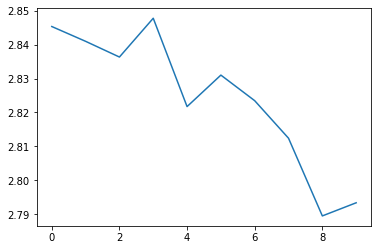

In [ ]:
plt.plot(all_losses)

In [ ]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-2.79) Russian
(-2.79) Chinese
(-2.82) English

> Jackson
(-2.74) Russian
(-2.75) Dutch
(-2.77) Japanese

> Satoshi
(-2.53) Italian
(-2.66) Japanese
(-2.82) Chinese


## 代码练习

In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names/Dutch.txt', 'data/names/German.txt', 'data/names/English.txt', 'data/names/Irish.txt', 'data/names/Arabic.txt', 'data/names/Greek.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/Czech.txt', 'data/names/French.txt', 'data/names/Chinese.txt', 'data/names/Scottish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt', 'data/names/Italian.txt', 'data/names/Korean.txt']


In [6]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [7]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [8]:
category_lines = {}
all_categories = []


for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [9]:
print(category_lines['Japanese'][:5])

['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara']


### 将surnames转成tensor

In [10]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [11]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [12]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [13]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.7709, -2.9190, -2.8059, -2.8866, -2.9581, -2.9849, -2.9121, -2.7534,
         -2.9330, -2.9805, -2.9146, -2.8211, -2.9468, -2.9216, -2.8976, -2.8850,
         -2.9352, -2.8404]], grad_fn=<LogSoftmaxBackward>)


In [14]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 7)


In [15]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Irish / line = Naomhan
category = Irish / line = Treasach
category = Japanese / line = Yamamoto
category = Greek / line = Maneates
category = Vietnamese / line = Duong
category = Russian / line = Javoronok
category = English / line = Eley
category = Scottish / line = Ferguson
category = German / line = Kruse
category = French / line = Sauveterre


In [38]:
criterion = nn.NLLLoss()

In [39]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

   
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [40]:
n_iters = 100000
print_every = 5000
plot_every = 1000


current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

   
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s)  %s / %s %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (2.193427562713623)  Havroshkin / Greek ✗ (Russian)
10000 10% (0.8114324808120728)  Garofalis / Greek ✓
15000 15% (2.3954954147338867)  Tosi / Korean ✗ (Italian)
20000 20% (0.977168619632721)  Tze / Chinese ✓
25000 25% (1.7284306287765503)  Doyle / Irish ✓
30000 30% (0.9015117883682251)  Schwarzenegger / Dutch ✗ (German)
35000 35% (2.1742377281188965)  Abreu / Dutch ✗ (Portuguese)
40000 40% (1.9753971099853516)  Zavala / Italian ✗ (Spanish)
45000 45% (0.35565072298049927)  Samaha / Arabic ✓
50000 50% (1.5931611061096191)  Vlasek / Polish ✗ (Czech)
55000 55% (5.699963092803955)  Twigg / Chinese ✗ (English)
60000 60% (2.09792423248291)  Vykruta / Japanese ✗ (Czech)
65000 65% (0.4028301239013672)  Ferro / Portuguese ✓
70000 70% (1.6772114038467407)  Kvasnicka / Polish ✗ (Czech)
75000 75% (0.37365856766700745)  So / Korean ✓
80000 80% (1.8588064908981323)  Beringer / French ✗ (German)
85000 85% (0.6250619292259216)  Vega / Spanish ✓
90000 90% (2.554600715637207)  Habin / Arabic ✗ (

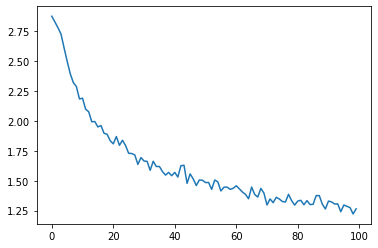

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

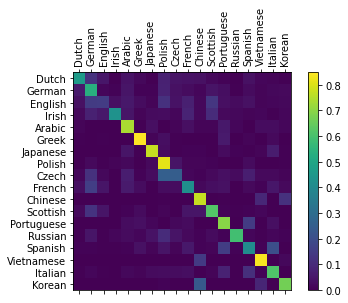

In [42]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1


for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)


ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [43]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.81) Czech
(-0.97) Russian
(-2.89) Polish

> Jackson
(-0.59) Scottish
(-1.81) Russian
(-2.12) English

> Satoshi
(-0.96) Italian
(-1.54) Portuguese
(-1.93) Japanese


### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

In [44]:
#add linear layers
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [45]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8585, -2.9187, -2.9025, -2.9171, -2.9672, -2.9171, -2.9010, -2.7754,
         -2.7834, -2.9476, -2.8782, -2.8917, -2.8041, -2.9062, -2.8850, -2.9593,
         -2.9915, -2.8531]], grad_fn=<LogSoftmaxBackward>)


In [46]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 7)


In [47]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Hyun 
category = Vietnamese / line = Quang
category = Irish / line = Simon
category = Scottish / line = Mckenzie
category = Czech / line = Borovka
category = Irish / line = Cearbhall
category = German / line = Pawlitzki
category = Korean / line = Jong
category = Italian / line = Napoletani
category = French / line = Favager


In [48]:
criterion = nn.NLLLoss()

In [49]:
learning_rate = 0.005 

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [50]:
n_iters = 100000
print_every = 5000
plot_every = 1000


current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s)  %s / %s %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (2.837373733520508)  Chaput / English ✗ (French)
10000 10% (2.4057719707489014)  De santigo / Portuguese ✓
15000 15% (2.5421054363250732)  Clegg / German ✗ (English)
20000 20% (2.9963221549987793)  Rose / English ✗ (German)
25000 25% (1.9947108030319214)  Larue / English ✗ (French)
30000 30% (1.4469538927078247)  Damhan / Arabic ✗ (Irish)
35000 35% (3.56813383102417)  Gentile / French ✗ (Italian)
40000 40% (1.1903797388076782)  Slusarski / Japanese ✗ (Polish)
45000 45% (1.8827481269836426)  Franco / Italian ✗ (Portuguese)
50000 50% (1.580945372581482)  Rim / Korean ✓
55000 55% (0.18415474891662598)  Funakoshi / Japanese ✓
60000 60% (4.15769100189209)  Hanania / Russian ✗ (Arabic)
65000 65% (2.1324429512023926)  Pierce / French ✗ (English)
70000 70% (4.522136211395264)  Rompa / Portuguese ✗ (Dutch)
75000 75% (1.1389333009719849)  Laberenz / Spanish ✗ (German)
80000 80% (2.5997796058654785)  Makushok / Japanese ✗ (Russian)
85000 85% (4.572159767150879)  Desrosiers / Dutch ✗ (Fren

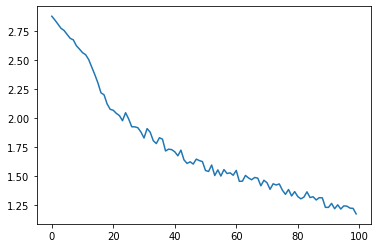

In [51]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

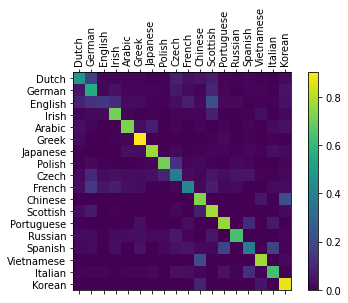

In [52]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1


for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)


ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [53]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Smith')
predict('Satoshi')


> Dovesky
(-0.55) Russian
(-1.54) Czech
(-2.31) Polish

> Smith
(-0.29) Scottish
(-2.41) German
(-3.45) English

> Satoshi
(-1.26) Italian
(-1.36) Japanese
(-1.90) Polish


### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

In [54]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.LSTM(input_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        output, hidden = self.i2h(input)
        output = self.i2o(output[-1])
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
        
n_hidden = 128
model_2 = LSTM(n_letters, n_hidden, 18)

In [55]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, 1, n_hidden)

output, next_hidden = model_2(input)
print(output)

tensor([[-2.9830, -2.8092, -2.8752, -2.9148, -2.8301, -2.9864, -2.9587, -2.9817,
         -2.8178, -2.8190, -2.8564, -2.8529, -2.8529, -2.9273, -2.8655, -2.8634,
         -2.9460, -2.9178]], grad_fn=<LogSoftmaxBackward>)


In [56]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 1)


In [57]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Hayward
category = Chinese / line = Sun
category = Portuguese / line = Belo
category = Irish / line = Carey
category = Scottish / line = Allan
category = Russian / line = Belousko
category = Spanish / line = Duarte
category = English / line = Elmhirst
category = Scottish / line = Johnston
category = Chinese / line = Lim


### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

In [58]:
criterion = nn.NLLLoss()

In [59]:
learning_rate = 0.005 

def train(category_tensor, line_tensor):
    hidden = model_2.initHidden()

    model_2.zero_grad()

    
    output, hidden = model_2(line_tensor)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in model_2.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [60]:
n_iters = 100000
print_every = 5000
plot_every = 1000


current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s)  %s / %s %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (2.9352269172668457)  Inoue / Polish ✗ (Japanese)
10000 10% (2.8315157890319824)  O'Grady / Arabic ✗ (Irish)
15000 15% (2.9634246826171875)  Glockl / Greek ✗ (Czech)
20000 20% (1.994674563407898)  Belesis / Greek ✓
25000 25% (2.9417099952697754)  Von brandt / Greek ✗ (German)
30000 30% (1.6987518072128296)  Pak / Chinese ✗ (Korean)
35000 35% (4.034075736999512)  Shirane / French ✗ (Japanese)
40000 40% (2.643242359161377)  Miller / German ✗ (Scottish)
45000 45% (3.2064061164855957)  Douglas / Greek ✗ (Scottish)
50000 50% (1.248937726020813)  Chi / Vietnamese ✗ (Chinese)
55000 55% (1.8479825258255005)  Robert / German ✗ (French)
60000 60% (1.0203723907470703)  Chu / Vietnamese ✓
65000 65% (1.3108636140823364)  O'Neill / Irish ✓
70000 70% (1.3543548583984375)  Schmidt / German ✓
75000 75% (1.002565622329712)  Lim  / Korean ✓
80000 80% (2.090017795562744)  Heidl / English ✗ (Czech)
85000 85% (0.7573952674865723)  Tieu / Vietnamese ✓
90000 90% (3.8214950561523438)  Chmiel / English 

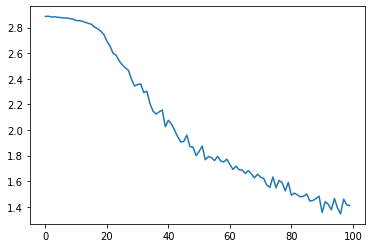

In [61]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

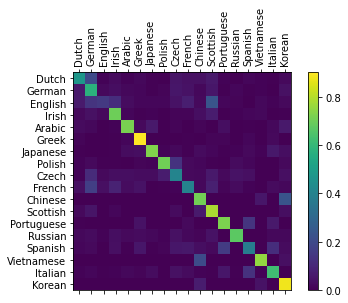

In [62]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1


for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)


ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

In [63]:
#LSTM+RNN

import torch.nn as nn

class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        output, hidden = self.lstm(input)
        output, hidden = self.rnn(output, hidden[0])
        output = self.linear(output[-1])
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

n_hidden = 128
model_3 = RNN_LSTM(n_letters, n_hidden, n_categories)

In [64]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, 1, n_hidden)

output, next_hidden = model_3(input)
print(output)

tensor([[-0.0542, -0.1112, -0.0833,  0.0950, -0.0642, -0.1920,  0.0527, -0.0077,
         -0.0628,  0.0104, -0.0594,  0.0406, -0.0672, -0.0055, -0.1023, -0.0633,
         -0.0724,  0.0860]], grad_fn=<AddmmBackward>)


In [65]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 3)


In [66]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Takagawa
category = Polish / line = Szweda
category = English / line = Waller
category = Vietnamese / line = Phi
category = Irish / line = O'Keefe
category = Arabic / line = Deeb
category = Irish / line = Naoimhin
category = Dutch / line = Rijnder
category = French / line = Charpentier
category = Dutch / line = Houten


In [67]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()

In [68]:
learning_rate = 0.005 

def train(category_tensor, line_tensor):
    hidden = model_3.initHidden()

    model_3.zero_grad()

    
    output, hidden = model_3(line_tensor)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in model_3.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [69]:
n_iters = 100000
print_every = 5000
plot_every = 1000


current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s)  %s / %s %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (3.123809814453125)  Geier / Arabic ✗ (German)
10000 10% (3.1228160858154297)  Young / Arabic ✗ (Scottish)
15000 15% (2.7205889225006104)  Mooney / Scottish ✗ (Irish)
20000 20% (2.2411746978759766)  Oirschotten / Irish ✗ (Dutch)
25000 25% (2.4015862941741943)  Zambrano / Japanese ✗ (Spanish)
30000 30% (1.8161519765853882)  Lee / Chinese ✗ (Korean)
35000 35% (0.6419191956520081)  Porokhov / Russian ✓
40000 40% (2.0360474586486816)  Andel / German ✗ (Dutch)
45000 45% (4.909980297088623)  Nemoto / Portuguese ✗ (Japanese)
50000 50% (0.14998388290405273)  Agelakos / Greek ✓
55000 55% (4.760387420654297)  Altena / Portuguese ✗ (Dutch)
60000 60% (0.06287690997123718)  Pappayiorgas / Greek ✓
65000 65% (0.9566289186477661)  Abbatantuono / Greek ✗ (Italian)
70000 70% (0.8910706639289856)  Jeon / Korean ✓
75000 75% (0.7708255648612976)  Tron / Vietnamese ✓
80000 80% (5.082045555114746)  Zaloumi / Italian ✗ (Greek)
85000 85% (0.5186841487884521)  Cablikova / Czech ✓
90000 90% (0.0685751885

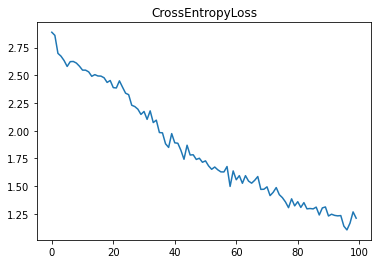

In [70]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.title('CrossEntropyLoss')
plt.plot(all_losses)

采用nn.NLLLoss的loss


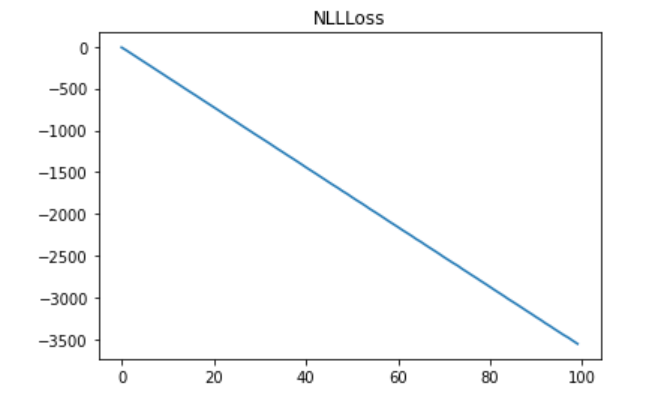



In [ ]:
##LSTM+RNN，使用nn.NLLLoss()居然losses成了一条直线，不知为何？改为nn.CrossEntropLoss()，炼丹调参